In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import sys
sys.path.append('../ca2-mec')
import data_processing as dp
from trackunitmulticomparison import TrackMultipleSessions
from registration import store_notebook
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import quantities as pq
import exdir
from distutils.dir_util import copy_tree
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import networkx as nx
#from nxpd import draw
%matplotlib inline

In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

identify_neurons = project.require_action('identify-neurons')
data_loader = dp.Data()

In [4]:
include = ['011-280721-1', '011-280721-2']

# find the complement of include
skip_actions = []
for action in actions:
    if action not in include:
        skip_actions.append(action)
skip_actions, include

(['001-280721-3',
  '001-280721-1',
  'identify-neurons',
  '001-280721-4',
  '001-280721-2'],
 ['011-280721-1', '011-280721-2'])

In [5]:
sessions = []
for action in actions.values():
    if action.id in skip_actions:
        continue
    if action.type != 'Recording':
        continue
    print(action.id)
    action_data_path = dp.get_data_path(action)
    exdir_object =  exdir.File(action_data_path)
    if 'processing' not in exdir_object:
        continue
        
    processing = exdir_object['processing']
    
    if not 'electrophysiology' in processing:
        continue
    elphys = processing['electrophysiology']
    if 'spikesorting' not in elphys:
        continue  

    sessions.append({
       'action': action.id,
       'session': int(action.id.split('-')[-1]),
       'entity': action.entities[0],

   })
sessions = pd.DataFrame(sessions)

011-280721-2
011-280721-1


In [6]:
sessions['date'] = sessions.apply(lambda x: x.action.split('-')[1], axis=1)
sessions['entity_date'] = sessions.apply(lambda x: '-'.join(x.action.split('-')[:2]), axis=1)
sessions.to_csv(identify_neurons.data_path() / 'sessions.csv', index=False)
sessions

,action,session,entity,date,entity_date
0,011-280721-2,2,011,280721,011-280721
1,011-280721-1,1,011,280721,011-280721


# Identify unique neurons

In [7]:
sessions_include = sessions.query("action.isin(@include)")
sessions_include

,action,session,entity,date,entity_date
0,011-280721-2,2,011,280721,011-280721
1,011-280721-1,1,011,280721,011-280721


In [8]:
# save graphs
for entity, values in sessions_include.groupby('entity'):
    print(entity, values)
    data_path = identify_neurons.data_path() / f'{entity}-graphs'
    if data_path.exists():
        shutil.rmtree(data_path)
#         continue
    unit_matching = TrackMultipleSessions(
        actions, action_list=values.action.values.tolist(), 
        progress_bar=tqdm, verbose=False, data_path=data_path
    )
    unit_matching.do_matching()
    unit_matching.make_graphs_from_matches()
#     unit_matching.compute_time_delta_edges()
    unit_matching.compute_depth_delta_edges()
    # save graph with all dissimilarities for later use
    unit_matching.save_graphs()

011          action  session entity    date entity_date
0  011-280721-2        2    011  280721  011-280721
1  011-280721-1        1    011  280721  011-280721


  0%|          | 0/1 [00:00<?, ?it/s]

# Plot comparisons

In [9]:
entity = "011"
unit_comp = TrackMultipleSessions(
    actions, sessions_include.action.values, data_path=identify_neurons.data_path() / f'{entity}-graphs')

unit_comp.load_graphs()

In [10]:
max_dissimilarity = .05
max_depth_delta = 100

unit_comp.remove_edges_above_threshold('weight', max_dissimilarity)
unit_comp.remove_edges_above_threshold('depth_delta', max_depth_delta)

unit_comp.remove_edges_with_duplicate_actions()
unit_comp.identify_units()

Zero units found on channel group 0
Zero units found on channel group 2
Zero units found on channel group 4
Zero units found on channel group 6
Zero units found on channel group 7


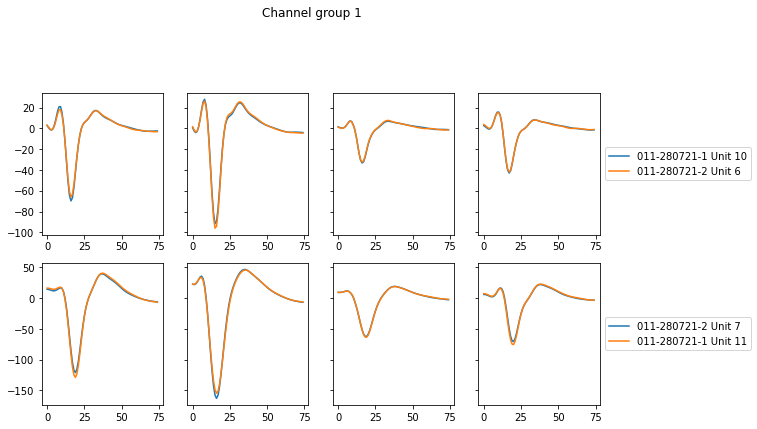

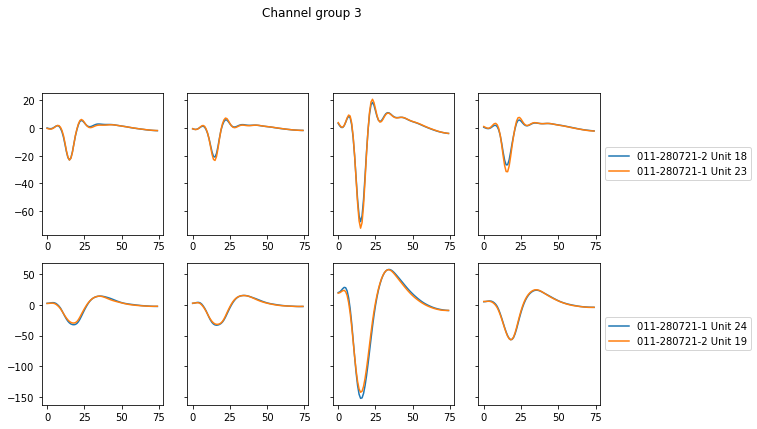

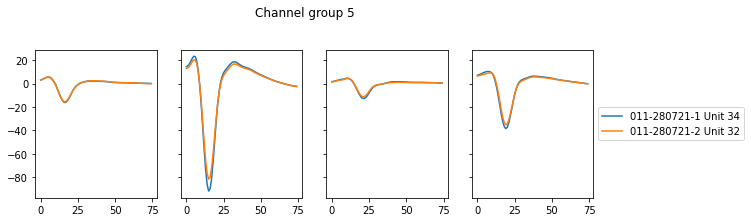

In [11]:
#unit_comp.plot_matches('template', chan_group=1, step_color=False)
unit_comp.plot_matches('template', step_color=False)

#plt.tight_layout()

# Store uniqe unit ids to csv

In [12]:
max_dissimilarity = .05
max_depth_delta = 100
id_nums = {}
num = 0
output = identify_neurons.data_path()

for entity, values in sessions_include.groupby('entity'):
    data_path = output / f'{entity}-graphs'
    unit_matching = TrackMultipleSessions(
        actions, values.action.values.tolist(), 
        progress_bar=tqdm, verbose=False, data_path=data_path
    )
    unit_matching.load_graphs()
    # cutoff large dissimilarities
    unit_matching.remove_edges_above_threshold('weight', max_dissimilarity)
    unit_matching.remove_edges_above_threshold('depth_delta', max_depth_delta)
    unit_matching.remove_edges_with_duplicate_actions()
    unit_matching.identify_units()
    units = []
    for ch, group in unit_matching.identified_units.items():
        for unit_id, val in group.items():
            for action_id, orig_unit_ids in val['original_unit_ids'].items():
                if unit_id not in id_nums:
                    id_nums[unit_id] = num
                    num += 1
                units.extend([
                    {
                        'unit_name': name, 
                        'unit_idnum': id_nums[unit_id],
                        'unit_id': unit_id, 
                        'action': action_id,
                        'channel_group': ch,
                        'max_dissimilarity': max_dissimilarity,
                        'max_depth_delta': max_depth_delta
                    } 
                    for name in orig_unit_ids])
    units = pd.DataFrame(units)
    units = units[~units.action.isin(skip_actions)]
    units.to_csv(output / f'{entity}-units.csv', index=False)

In [13]:
unique_units = pd.concat([
    pd.read_csv(p) 
    for p in output.iterdir() 
    if p.name.endswith('-units.csv')])

In [14]:
unique_units.to_csv(output / 'units.csv', index=False)

# Store results in Expipe action

In [15]:
identify_neurons.data['sessions'] = 'sessions.csv'
identify_neurons.data['units'] = 'units.csv'

In [16]:
copy_tree(output, str(identify_neurons.data_path()))

['/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-7.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-6.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-4.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-3.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-1.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-5.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-0.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-2.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-units.csv',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/00-identify-neurons.html',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/units.csv',
 '/mnt/WD12TB-HDD/data/ca2mec

In [17]:
store_notebook(
    identify_neurons, "00-identify-neurons.ipynb")

## Load and view results

In [29]:
pd.read_csv(output / "units.csv")

,unit_name,unit_idnum,unit_id,action,channel_group,max_dissimilarity,max_depth_delta
0,1,0,71779b60-234a-4cc3-97e7-6ea0d681db97,011-280721-1,0,0.05,100
1,5,1,2e37ce55-8edd-49a5-be34-a8e999440b23,011-280721-1,0,0.05,100
2,6,2,2268d288-88c5-4d32-ba6d-5cdcc7f7ba3c,011-280721-1,0,0.05,100
3,10,3,4a53a802-98eb-43fc-a3ac-827993b46805,011-280721-1,1,0.05,100
4,6,3,4a53a802-98eb-43fc-a3ac-827993b46805,011-280721-2,1,0.05,100
5,7,4,932e4346-d3d6-4a86-be01-0984fe51aa9a,011-280721-2,1,0.05,100
6,11,4,932e4346-d3d6-4a86-be01-0984fe51aa9a,011-280721-1,1,0.05,100
7,5,5,02418f8a-c0de-4a71-989e-19abfb7209ec,011-280721-2,1,0.05,100
8,19,6,a4b5b165-4ed2-447f-8142-30599d5890f5,011-280721-1,2,0.05,100
9,20,7,3c319d23-57d0-4f63-8400-1445689a2c9c,011-280721-1,2,0.05,100


In [19]:
pd.read_csv(output / "units.csv")["unit_id"].unique()

array(['71779b60-234a-4cc3-97e7-6ea0d681db97',
       '2e37ce55-8edd-49a5-be34-a8e999440b23',
       '2268d288-88c5-4d32-ba6d-5cdcc7f7ba3c',
       '4a53a802-98eb-43fc-a3ac-827993b46805',
       '932e4346-d3d6-4a86-be01-0984fe51aa9a',
       '02418f8a-c0de-4a71-989e-19abfb7209ec',
       'a4b5b165-4ed2-447f-8142-30599d5890f5',
       '3c319d23-57d0-4f63-8400-1445689a2c9c',
       '03a785cf-bae3-4148-b632-edf2966d7e32',
       'eef081ca-22cd-4a37-8a24-38ffbd2b9a83',
       'ec03ca63-da7b-4370-af27-c74297a7721b',
       '28ee18ad-d33b-49ee-aeff-8f556dad2dc4',
       'ae32f019-5774-40e5-82e1-bd98db898fca',
       '6877c90c-ee97-4c6b-af63-f5d097522b4c',
       '46272473-4837-4266-a0f3-c9974be92b32',
       '7f1e6e63-7292-4f30-93c9-7284266dff11',
       'ce327964-2486-48f5-9017-72292461800f',
       '3ae47fbc-a4f6-4443-8359-81e773e25302',
       '34b403de-edac-402d-9e35-ee44f92c7769'], dtype=object)